In [2]:
# importing libraries

import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

C:\Users\aravi\AppData\Local\Temp/ipykernel_17272/278076013.py:8: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [3]:
# importing data 

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sub = pd.read_csv('sample_submission.csv')

## EDA

In [4]:
train.head()

,row_id,user_id,category_id,video_id,age,gender,profession,followers,views,engagement_score
0,1,19990,37,128,24,Male,Student,180,1000,4.33
1,2,5304,32,132,14,Female,Student,330,714,1.79
2,3,1840,12,24,19,Male,Student,180,138,4.35
3,4,12597,23,112,19,Male,Student,220,613,3.77
4,5,13626,23,112,27,Male,Working Professional,220,613,3.13


In [5]:
train.isnull().sum()

row_id              0
user_id             0
category_id         0
video_id            0
age                 0
gender              0
profession          0
followers           0
views               0
engagement_score    0
dtype: int64

In [6]:
train.shape

(89197, 10)

In [7]:
train.profession.value_counts()

Student                 44638
Other                   26840
Working Professional    17719
Name: profession, dtype: int64

In [8]:
train.gender.value_counts()

Male      52397
Female    36800
Name: gender, dtype: int64

In [9]:
len(train.category_id.value_counts())

47

In [10]:
def hist(column):
    """ This function helps to visulaize the histogram of the repective column """
    
    train[column].hist()
    plt.axvline(x = train[column].mean(), color = 'red', label = 'Mean')
    plt.axvline(x = train[column].median(), color = 'orange', label = 'Median')
    plt.axvline(x = train[column].mode()[0], color = 'pink', label = 'Mode')
    plt.xticks(color = 'green')
    plt.yticks(color = 'red')
    plt.title(f"{column}_Distribution", color = 'yellow')
    plt.legend()
    plt.grid(color = 'grey');

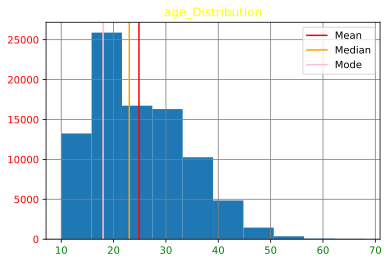

In [11]:
# Let's see the distribution for age 

hist('age')

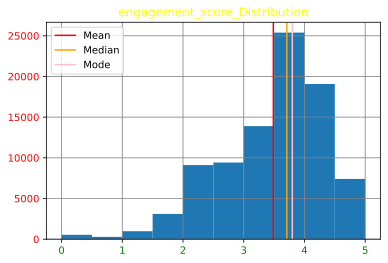

In [12]:
hist('engagement_score')

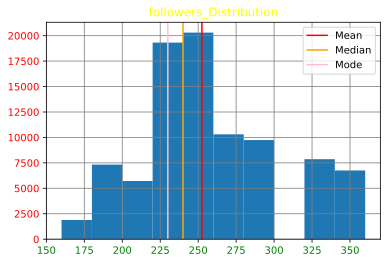

In [13]:
hist('followers')

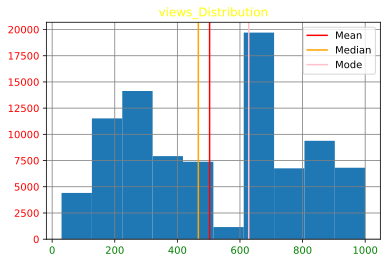

In [14]:
hist('views')

In [15]:
train.head()

,row_id,user_id,category_id,video_id,age,gender,profession,followers,views,engagement_score
0,1,19990,37,128,24,Male,Student,180,1000,4.33
1,2,5304,32,132,14,Female,Student,330,714,1.79
2,3,1840,12,24,19,Male,Student,180,138,4.35
3,4,12597,23,112,19,Male,Student,220,613,3.77
4,5,13626,23,112,27,Male,Working Professional,220,613,3.13


### Observations: 
* I don't see much oultiers here and some of the features following normal distributions and some of them are not following the normal distribution. 
* We, can scale our data with **Min Max Scaler** coz all are different distributions. 
* No null values also. 
* Let's imputate the categorical values. 


In [16]:
# let's encode the data: 

dic = {'Male':0, 'Female':1}
train['gender'] = train['gender'].map(dic)

train['profession'] = label_encoder.fit_transform(train['profession'])

In [17]:
train.head()

,row_id,user_id,category_id,video_id,age,gender,profession,followers,views,engagement_score
0,1,19990,37,128,24,0,1,180,1000,4.33
1,2,5304,32,132,14,1,1,330,714,1.79
2,3,1840,12,24,19,0,1,180,138,4.35
3,4,12597,23,112,19,0,1,220,613,3.77
4,5,13626,23,112,27,0,2,220,613,3.13


In [18]:
# let's seprate the data... 

x = train.drop(['row_id', 'user_id', 'engagement_score'], axis = 1)
y = train.engagement_score

xtrain, xtest, ytrain, ytest = train_test_split(x,y, test_size = .3)

In [19]:
# let's scale the values 

scaler = MinMaxScaler()
xtrain = scaler.fit_transform(xtrain)
xtest = scaler.transform(xtest)

In [20]:
# let's visualize this.. 

xtrain = pd.DataFrame(xtrain, columns = x.columns)
xtest = pd.DataFrame(xtest, columns = x.columns)

In [21]:
xtrain

,category_id,video_id,age,gender,profession,followers,views
0,0.086957,0.045977,0.051724,1.0,0.5,0.40,0.205155
1,0.652174,0.482759,0.086207,0.0,0.5,0.35,0.129897
2,0.152174,0.086207,0.137931,0.0,0.5,0.60,0.616495
3,0.521739,0.856322,0.120690,1.0,0.5,0.40,0.295876
4,0.717391,0.655172,0.017241,1.0,0.5,0.35,0.835052
...,...,...,...,...,...,...,...
62432,0.086957,0.505747,0.379310,1.0,0.0,0.40,0.205155
62433,0.521739,0.586207,0.120690,0.0,0.5,0.40,0.295876
62434,0.717391,0.540230,0.137931,1.0,0.5,0.35,0.835052
62435,0.673913,0.758621,0.396552,0.0,0.0,0.85,0.705155


Our data is changed between 0 to 1 


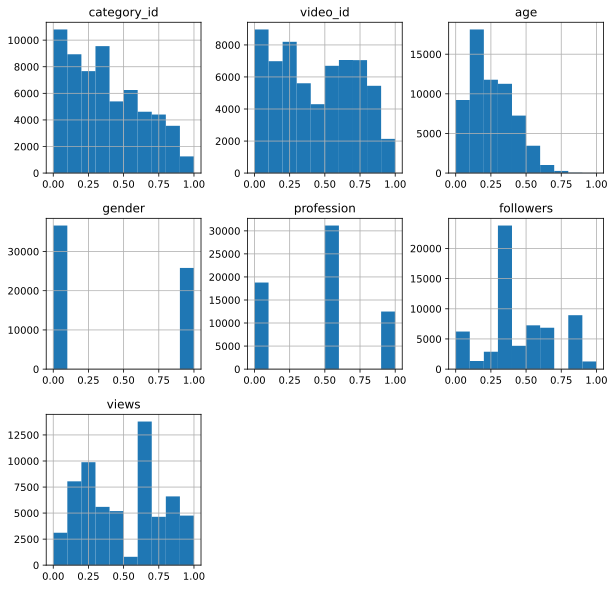

In [22]:

xtrain.hist(figsize = (10,10));
plt.title([x.columns], color = 'yellow')
# plt.xticks(color = 'green')
# plt.yticks(color = 'red')
print('Our data is changed between 0 to 1 ')

### Observations:
* Our data is well scaled now. 
* Imputed the values. 
* No outliers, No missing values. 
* Our Data is now **clean!**. 
* Let's build the model!

In [23]:
# Linear Regression! 

from sklearn.linear_model import LinearRegression 
lr = LinearRegression().fit(xtrain, ytrain)
pred = lr.predict(xtest)
print(f'Your R2: {r2_score(ytest, pred)}')

Your R2: 0.23563229390177465


Linear guy is bad!

In [24]:
# XG Booster :)))))))))

from xgboost import XGBRegressor
regressor = XGBRegressor().fit(xtrain,ytrain)
pred = regressor.predict(xtest)
print(f'Your R2: {r2_score(ytest, pred)}')

Your R2: 0.3461791902115573


Let's do some hyperparameter tunning to get rid away from this negative value ... .. . 

In [25]:
# Let select some parameters 

params = { 'learning_rate': ['0.05', '0.01', '0.09', '0.09', '0.001'], 
          'max_depth': [3, 4, 5, 8, 9, 12, 19, 1, ], # 
          'gamma': [0.01, 0.02, 0.03, 0.04, 0.05], 
          'colsample_bytree': [0.3, 0.4, 0.5, 0.8]}

random = RandomizedSearchCV(regressor, param_distributions= params, n_iter= 5, scoring = 'r2', cv =5, verbose = 3)


In [26]:
random.fit(x, y)
""" Run this code, commented due to long output"""

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END colsample_bytree=0.5, gamma=0.02, learning_rate=0.05, max_depth=12;, score=0.360 total time=   2.6s
[CV 2/5] END colsample_bytree=0.5, gamma=0.02, learning_rate=0.05, max_depth=12;, score=0.350 total time=   2.5s
[CV 3/5] END colsample_bytree=0.5, gamma=0.02, learning_rate=0.05, max_depth=12;, score=0.349 total time=   2.6s
[CV 4/5] END colsample_bytree=0.5, gamma=0.02, learning_rate=0.05, max_depth=12;, score=0.349 total time=   2.6s
[CV 5/5] END colsample_bytree=0.5, gamma=0.02, learning_rate=0.05, max_depth=12;, score=0.350 total time=   2.6s
[CV 1/5] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.01, max_depth=8;, score=-1.445 total time=   1.3s
[CV 2/5] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.01, max_depth=8;, score=-1.431 total time=   1.3s
[CV 3/5] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.01, max_depth=8;, score=-1.471 total time=   1.2s
[CV 4/5] END colsample_bytree=0.3, g

' Run this code, commented due to long output'

In [27]:
random.best_params_

{'max_depth': 8,
 'learning_rate': '0.09',
 'gamma': 0.05,
 'colsample_bytree': 0.4}

In [28]:
cl = XGBRegressor(colsample_bytree=0.4, gamma=0.05, learning_rate='0.09',max_depth=8)
cl.fit(xtrain,ytrain)
pred = cl.predict(xtest)
print(f'Your R2: {r2_score(ytest,pred)}')

Your R2: 0.3459720531423588


#### Run Various models 

In [29]:
#Running various models

from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor 


models = []
models.append(('Decison', DecisionTreeRegressor()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('GBR',GradientBoostingRegressor())) 
models.append(('RFR',RandomForestRegressor()))

# Gamma controls the over fitting 
import time

# evaluate each model in turn
results = []
names = []
scoring = 'r2'

for name, model in models:
    start_time = time.time()
    model.fit(xtrain, ytrain)

    y_pred = model.predict(xtest)
    predictions = [round(value) for value in y_pred]


    # evaluate predictions
    accuracy = r2_score(ytest, predictions)
    print("r2_socre: %.2f%%" % (accuracy * 100.0),name)
    print("--- %s seconds ---" % (time.time() - start_time))
    

r2_socre: 1.43% Decison
--- 0.18400168418884277 seconds ---
r2_socre: 12.99% KNN
--- 1.0630316734313965 seconds ---
r2_socre: 23.22% GBR
--- 4.137543439865112 seconds ---
r2_socre: 11.73% RFR
--- 10.81172800064087 seconds ---


HyperParameter tunning for GBR

In [31]:
lr = {'learning_rate': [0.15, 0.1, 0.10, 0.05], 'n_estimators': [100, 200, 150, 150]}
tunning = RandomizedSearchCV(estimator = GradientBoostingRegressor(), param_distributions = lr, n_iter= 5, scoring = 'r2', cv =5, verbose = 3)

tunning.fit(xtrain, ytrain)
print(tunning.best_params_) # It will give the best parameters for gbd 
print(tunning.best_score_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END learning_rate=0.05, n_estimators=200;, score=0.344 total time=   6.3s
[CV 2/5] END learning_rate=0.05, n_estimators=200;, score=0.340 total time=   6.3s
[CV 3/5] END learning_rate=0.05, n_estimators=200;, score=0.346 total time=   6.3s
[CV 4/5] END learning_rate=0.05, n_estimators=200;, score=0.339 total time=   7.9s
[CV 5/5] END learning_rate=0.05, n_estimators=200;, score=0.350 total time=   9.1s
[CV 1/5] END learning_rate=0.15, n_estimators=200;, score=0.354 total time=   7.5s
[CV 2/5] END learning_rate=0.15, n_estimators=200;, score=0.350 total time=   8.1s
[CV 3/5] END learning_rate=0.15, n_estimators=200;, score=0.358 total time=   7.6s
[CV 4/5] END learning_rate=0.15, n_estimators=200;, score=0.349 total time=   6.7s
[CV 5/5] END learning_rate=0.15, n_estimators=200;, score=0.360 total time=   7.1s
[CV 1/5] END learning_rate=0.15, n_estimators=100;, score=0.349 total time=   3.8s
[CV 2/5] END learning_rate=

In [33]:
cl = GradientBoostingRegressor(n_estimators = 200, learning_rate = 0.15)
cl.fit(xtrain,ytrain)
pred = cl.predict(xtest)
print(f'Your R2: {r2_score(ytest,pred)}')

Your R2: 0.35163009741019424


Fine let's predicte the test set: 

In [36]:
dic = {'Male':0, 'Female':1}
test['gender'] = test['gender'].map(dic)

test['profession'] = label_encoder.fit_transform(test['profession'])
test = test.drop(['row_id', 'user_id'], axis = 1)

In [39]:
test = scaler.transform(test)

In [41]:

test = pd.DataFrame(test, columns = x.columns)

In [42]:
test

,category_id,video_id,age,gender,profession,followers,views
0,-0.021893,-0.005753,-0.175345,0.0,0.125,-0.803979,-0.030959
1,-0.022006,-0.005753,-0.175289,0.0,0.250,-0.803980,-0.030959
2,-0.022150,-0.005778,-0.175325,0.0,0.125,-0.804000,-0.030959
3,-0.022006,-0.005757,-0.175320,1.0,0.125,-0.803980,-0.030959
4,-0.021873,-0.005763,-0.175356,1.0,0.125,-0.803991,-0.030959
...,...,...,...,...,...,...,...
26755,-0.022181,-0.005768,-0.175361,0.0,0.125,-0.803991,-0.030959
26756,-0.022006,-0.005771,-0.175335,1.0,0.125,-0.803980,-0.030959
26757,-0.021821,-0.005758,-0.175315,0.0,0.125,-0.803986,-0.030960
26758,-0.022027,-0.005772,-0.175330,0.0,0.125,-0.803991,-0.030959


#### Let's predict  by usign GBM

In [43]:
pred = tunning.predict(test)

In [46]:
test_rowid = pd.read_csv('test.csv')
test_rowid = test_rowid['row_id']

In [48]:
final = pd.DataFrame(zip(test_rowid, pred), columns = ['row_id', 'engagement_score'])
final.head()

,row_id,engagement_score
0,89198,3.535678
1,89199,3.535678
2,89200,3.535678
3,89201,2.826666
4,89202,2.826666


In [49]:
final.to_csv('submission.csv',index = False)

### Let's try some deep learning model

In [ ]:
# train_neural = torch.tensor(x.values).float()
# test_neural = torch.tensor(y.values).long()
# x_train, x_test, y_train, y_test = train_test_split(train_neural, test_neural, test_size = 0.3)

In [ ]:
# class Ann(nn.Module): 
#   def __init__(self):
#     super().__init__()
#     self.input = nn.Linear(7, 29)
#     self.hidden1 = nn.Linear(29, 69)
#     self.hidden2 = nn.Linear(69,12)
#     self.hidden3 = nn.Linear(12,12)
#     self.output = nn.Linear(12, 1)

#   def forward(self, x): 
#     x = F.relu(self.input(x))
#     x = F.relu(self.hidden1(x))
#     x = F.relu(self.hidden2(x))
#     x = F.relu(self.hidden3(x))
#     x = self.output(x)
#     return x
# net = Ann()

In [ ]:
# def trainthemodel():
#     losses = []
#     predictions = []
#     lossfun = nn.MSELoss()
#     optimizer = torch.optim.Adam(net.parameters(), lr = .001)
#     epochs = 100

#     for i in range(epochs): 
#         yhat = net(x_train) 
#         loss = lossfun(yhat, y_train)
#         losses.append(loss.item())
#         predictions.append(torch.argmax(yhat, axis =1))
#         labels = torch.argmax( yhat, axis = 1)
#         labels = labels.numpy()

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step() 
#     return losses, labels

In [ ]:
# losses, preditions = trainthemodel()

* I can't do deep learning here :( 

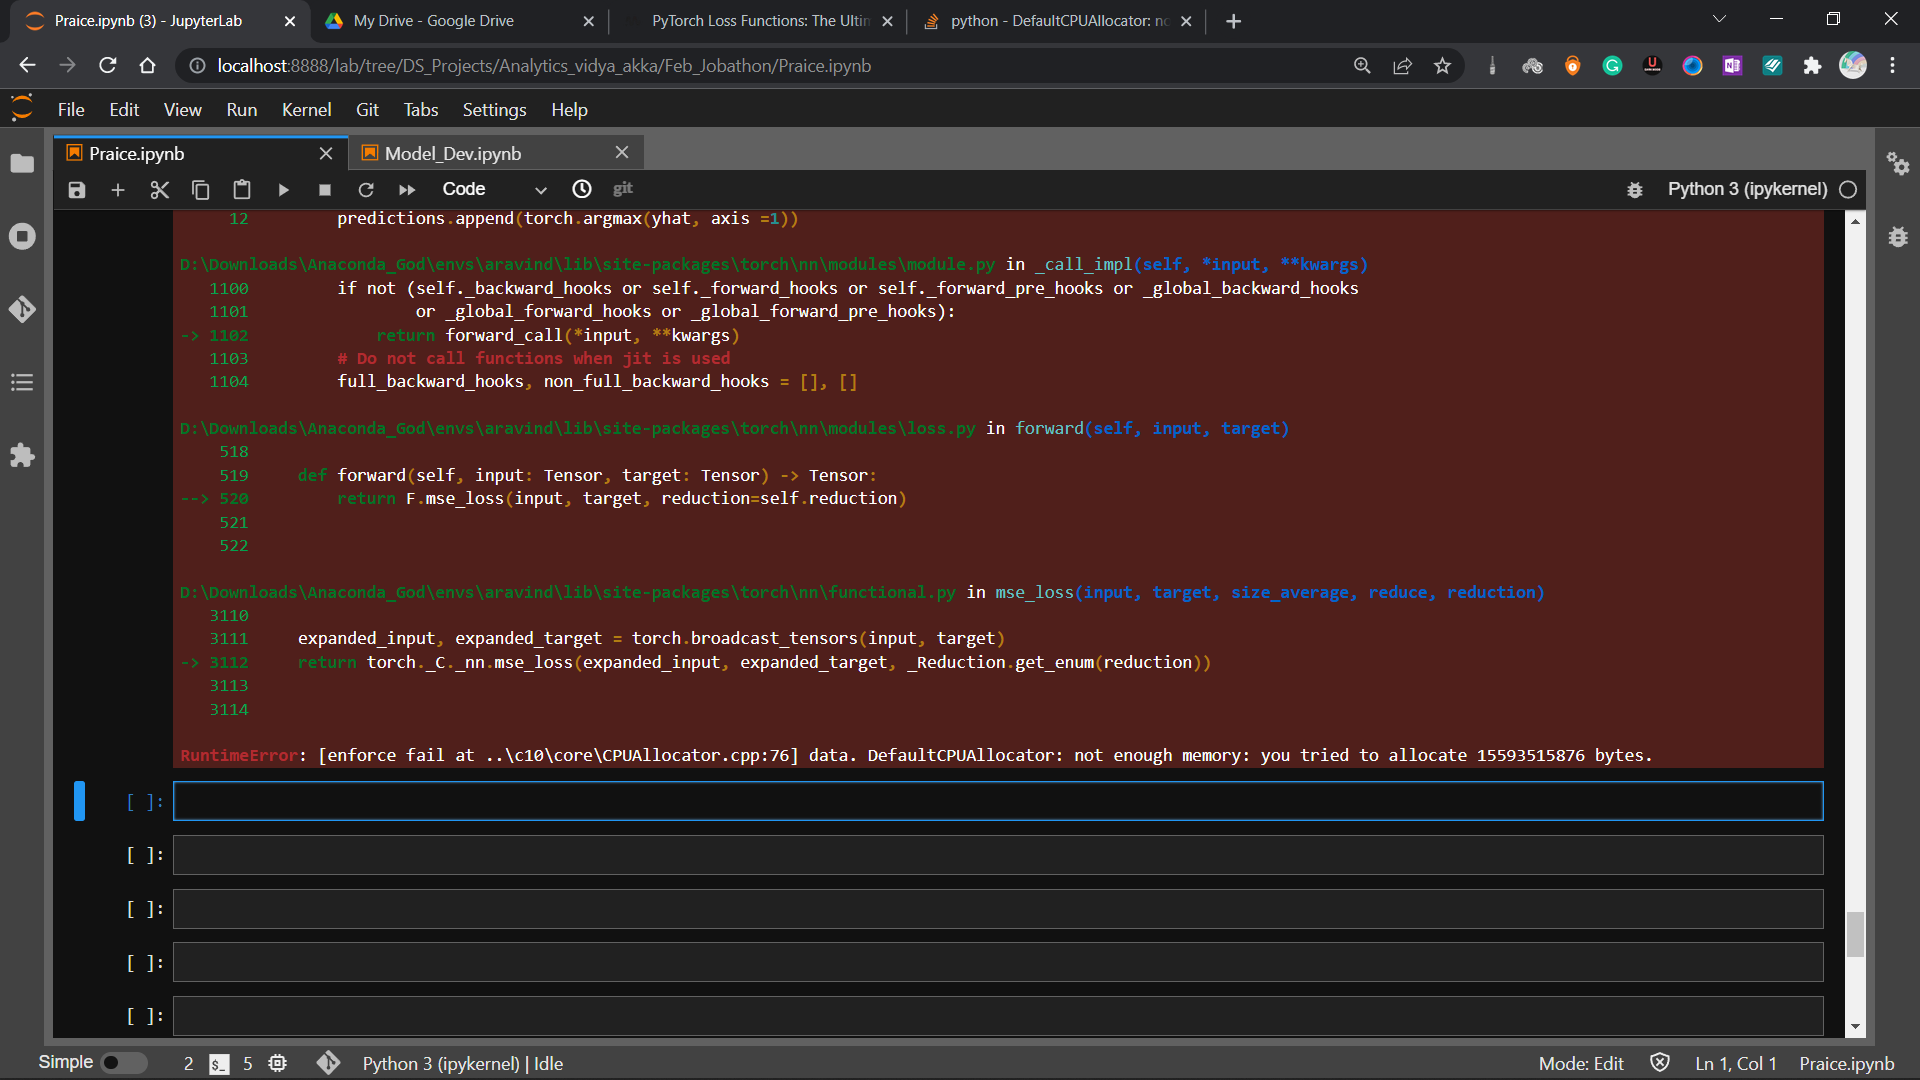

In [ ]:
train.profession.value_counts()

In [ ]:
train.gender.value_counts()

In [ ]:
train.age.hist()